### ST-GCNするよ

<https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/03_action_recognition_ST_GCN.ipynb>


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from persor import BVHparser
import matplotlib.pyplot as plt
import japanize_matplotlib

In [2]:
print("Use CUDA:", torch.cuda.is_available())

Use CUDA: False


In [3]:
# 再現性を担保

seed = 123

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [4]:
# 隣接行列を作成
class Graph:
    def __init__(self, hop_size, bvhp):
        self.node_num = len([j for j in bvhp.get_joints() if not j.startswith("_End_")])
        self.edge = self.__get_edge(bvhp.get_skeleton())

        # hop数分離れた関節を取得
        hop_dis = self.__get_hop_distance(self.node_num, self.edge, hop_size)

        # 隣接行列を作成
        self.A = self.__get_adjacency_mat(hop_dis, hop_size)

    def __str__(self):
        return self.A

    def __get_edge(self, skeleton):
        edge = []
        for _, data in skeleton.items():
            parent_id = data["id"]
            children = [j for j in data["children"] if not j.startswith("_End_")]
            children_ids = [skeleton[child]["id"] for child in children]
            edge.extend([(parent_id, child_id) for child_id in children_ids])
            edge.extend([(child_id, parent_id) for child_id in children_ids])
            edge.append((parent_id, parent_id))

        return edge

    def __get_hop_distance(self, node_num, edge, hop_size):
        A = np.zeros((node_num, node_num))

        for i, j in edge:
            A[j, i] = 1
            A[i, j] = 1

        hop_dis = np.zeros((node_num, node_num)) + np.inf
        transfer_mat = [np.linalg.matrix_power(
            A, d) for d in range(hop_size + 1)]
        arrive_mat = np.stack(transfer_mat) > 0

        [hop_dis[arrive_mat[d]] for d in range(hop_size + 1)]

        return hop_dis

    def __get_adjacency_mat(self, hop_dis, hop_size):
        valid_hop = range(0, hop_size + 1, 1)
        adjacency = np.where(np.isin(hop_dis, valid_hop), 1, 0)

        normalize_adjacency = self.__normalize_digraph(adjacency)
        A = np.array(
            [np.where(hop_dis == hop, normalize_adjacency, 0)
             for hop in valid_hop]
        )

        return A

    def __normalize_digraph(self, A):
        Dl = np.sum(A, axis=0)
        node_num = A.shape[0]
        Dn = np.diag([Dl[i] ** (-1) if Dl[i] >
                     0 else 0 for i in range(node_num)])
        DAD = np.dot(A, Dn)

        return DAD

In [5]:
# 空間畳み込みグラフ
class SpatialGraphConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, s_kernel_size):
        super().__init__()
        self.s_kernel_size = s_kernel_size
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels * s_kernel_size,
            kernel_size=1,
        )

    def forward(self, x, A):
        x = self.conv(x)
        n, kc, t, v = x.size()
        x = x.view(n, self.s_kernel_size, kc // self.s_kernel_size, t, v)
        # 隣接行列にGCを行い, 特徴を足し合わせています.
        x = torch.einsum("nkctv,kvw->nctw", (x, A))
        return x.contiguous()

In [6]:
# 何者?
class STGC_block(nn.Module):
    def __init__(
        self, in_channels, out_channels, stride, t_kernel_size, A_size, dropout=0.5
    ):
        super().__init__()
        # 空間グラフの畳み込み
        self.sgc = SpatialGraphConvolution(
            in_channels=in_channels, out_channels=out_channels, s_kernel_size=A_size[0]
        )

        # Learnable weight matrix M エッジに重みを与えます. どのエッジが重要かを学習します.
        self.M = nn.Parameter(torch.ones(A_size))

        self.tgc = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv2d(
                out_channels,
                out_channels,
                (t_kernel_size, 1),
                (stride, 1),
                ((t_kernel_size - 1) // 2, 0),
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x, A):
        x = self.tgc(self.sgc(x, A * self.M))
        return x

In [7]:
# モデルを定義
class ST_GCN(nn.Module):
    def __init__(self, num_classes, in_channels, t_kernel_size, hop_size, bvhp):
        super().__init__()
        # グラフ作成
        graph = Graph(hop_size, bvhp)
        A = torch.tensor(graph.A, dtype=torch.float32, requires_grad=False)
        self.register_buffer("A", A)
        A_size = A.size()

        # バッチ正規化
        self.bn = nn.BatchNorm1d(in_channels * A_size[1])

        # STGC_block
        self.stgc1 = STGC_block(in_channels, 32, 1, t_kernel_size, A_size)
        self.stgc2 = STGC_block(32, 32, 1, t_kernel_size, A_size)
        self.stgc3 = STGC_block(32, 32, 1, t_kernel_size, A_size)
        self.stgc4 = STGC_block(32, 64, 2, t_kernel_size, A_size)
        self.stgc5 = STGC_block(64, 64, 1, t_kernel_size, A_size)
        self.stgc6 = STGC_block(64, 64, 1, t_kernel_size, A_size)

        # 予測
        self.fc = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Batch Normalization
        N, C, T, V = x.size()  # batch, channel, frame, node
        x = x.permute(0, 3, 1, 2).contiguous().view(N, V * C, T)
        x = x.to(torch.float32)
        x = self.bn(x)
        x = x.view(N, V, C, T).permute(0, 2, 3, 1).contiguous()

        # STGC_blocks
        x = self.stgc1(x, self.A)
        x = self.stgc2(x, self.A)
        x = self.stgc3(x, self.A)
        x = self.stgc4(x, self.A)
        x = self.stgc5(x, self.A)
        x = self.stgc6(x, self.A)

        # Prediction
        x = F.avg_pool2d(x, x.size()[2:])
        x = x.view(N, -1, 1, 1)
        x = self.fc(x)
        x = x.view(x.size(0), -1)

        return x

In [8]:
# データセットの定義
class Feeder(torch.utils.data.Dataset):
    def __init__(self, data_path, label_path):
        super().__init__()
        self.data = np.load(data_path)
        self.label = np.load(label_path)

    def __len__(self):
        return len(self.label)

    def __iter__(self):
        return self

    def __getitem__(self, index):
        data = self.data[index]
        label = self.label[index]

        return data, label

In [9]:
# エポック数とバッチサイズ
NUM_EPOCH = 100
BATCH_SIZE = 64

# 骨格情報
bvhp = BVHparser("data/bvh/全て1.bvh")

# モデルを作成
model = ST_GCN(
    num_classes=5,
    in_channels=3,
    t_kernel_size=9,  # 時間グラフ畳み込みのカーネルサイズ (t_kernel_size × 1)
    hop_size=2,
    bvhp=bvhp,
)

# オプティマイザ
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 誤差関数
criterion = torch.nn.CrossEntropyLoss()

# データセットの用意
train_data = torch.utils.data.DataLoader(
    dataset=Feeder(data_path="data/train_data.npy", label_path="data/train_label.npy"),
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_data = torch.utils.data.DataLoader(
    dataset=Feeder(data_path="data/test_data.npy", label_path="data/test_label.npy"),
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# モデルを学習モードに変更
_ = model.train()

In [10]:
# 学習開始
for epoch in range(1, NUM_EPOCH + 1):
    correct = 0
    sum_loss = 0
    for batch_idx, (data, label) in enumerate(train_data):
        # data = data.cuda()
        # label = label.cuda()

        output = model(data)

        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        sum_loss += loss.item()
        _, predict = torch.max(output.data, 1)
        correct += (predict == label).sum().item()

    print(
        "# Epoch: {} | Loss: {:.4f} | Accuracy: {:.4f}".format(
            epoch,
            sum_loss / len(train_data.dataset),
            (100.0 * correct / len(train_data.dataset)),
        )
    )

# Epoch: 1 | Loss: 0.0325 | Accuracy: 19.0000
# Epoch: 2 | Loss: 0.0324 | Accuracy: 19.0000
# Epoch: 3 | Loss: 0.0324 | Accuracy: 19.0000
# Epoch: 4 | Loss: 0.0324 | Accuracy: 19.0000
# Epoch: 5 | Loss: 0.0324 | Accuracy: 19.0000
# Epoch: 6 | Loss: 0.0324 | Accuracy: 19.0000
# Epoch: 7 | Loss: 0.0323 | Accuracy: 19.0000
# Epoch: 8 | Loss: 0.0323 | Accuracy: 19.0000
# Epoch: 9 | Loss: 0.0323 | Accuracy: 19.0000
# Epoch: 10 | Loss: 0.0323 | Accuracy: 19.0000
# Epoch: 11 | Loss: 0.0322 | Accuracy: 19.0000
# Epoch: 12 | Loss: 0.0322 | Accuracy: 19.0000
# Epoch: 13 | Loss: 0.0322 | Accuracy: 19.0000
# Epoch: 14 | Loss: 0.0321 | Accuracy: 19.0000
# Epoch: 15 | Loss: 0.0321 | Accuracy: 19.0000
# Epoch: 16 | Loss: 0.0321 | Accuracy: 19.0000
# Epoch: 17 | Loss: 0.0321 | Accuracy: 24.0000
# Epoch: 18 | Loss: 0.0321 | Accuracy: 24.0000
# Epoch: 19 | Loss: 0.0321 | Accuracy: 24.0000
# Epoch: 20 | Loss: 0.0321 | Accuracy: 24.0000
# Epoch: 21 | Loss: 0.0320 | Accuracy: 24.0000
# Epoch: 22 | Loss: 0.

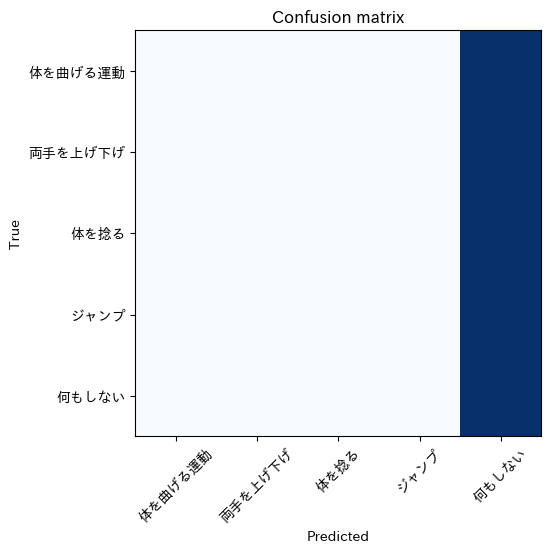

# Test Accuracy: 24.000[%]


In [14]:
# モデルを評価モードに変更
model.eval()

correct = 0
confusion_matrix = np.zeros((5, 5))
with torch.no_grad():
    for batch_idx, (data, label) in enumerate(test_data):
        # data = data.cuda()
        # label = label.cuda()

        output = model(data)

        _, predict = torch.max(output.data, 1)
        correct += (predict == label).sum().item()

        for l, p in zip(label.view(-1), predict.view(-1)):
            confusion_matrix[l.long(), p.long()] += 1

len_cm = len(confusion_matrix)
for i in range(len_cm):
    sum_cm = np.sum(confusion_matrix[i])
    for j in range(len_cm):
        confusion_matrix[i][j] = 100 * (confusion_matrix[i][j] / sum_cm)

classes = [
    "体を曲げる運動",
    "両手を上げ下げ",
    "体を捻る",
    "ジャンプ",
    "何もしない",
]
plt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.tight_layout()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

print(
    "# Test Accuracy: {:.3f}[%]".format(
        100.0 * correct / len(test_data.dataset)
    )
)